In [1]:
# CartPole
# Discrete Control input
# Actor Critic structure, with tensorflow
# using TD-error not Q learning as Advantage
# Advantage for Actor update

# Hope it works

import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

n_observation = 4
n_action = 2
n_hidden_c = 10
n_hidden_a = 10

# Critic Network used to estimate state value function v
tf_obs_c = tf.placeholder(tf.float32, [None, n_observation])
# layers
W1_c = tf.Variable(tf.random_normal([n_observation, n_hidden_c], stddev=0.1))
b1_c = tf.Variable(tf.random_normal([n_hidden_c]))
W2_c = tf.Variable(tf.random_normal([n_hidden_c, 1], stddev=0.1))
b2_c = tf.Variable(tf.random_normal([1]))
    
fc1_c = tf.nn.relu(tf.matmul(tf_obs_c, W1_c) + b1_c)
tf_v = tf.reduce_sum(tf.matmul(fc1_c, W2_c) + b2_c)

# training
tf_target_v = tf.placeholder(tf.float32, [None, 1])
loss_c = tf.reduce_sum(tf.square(tf_target_v - tf_v))
trainer_c = tf.train.AdamOptimizer(0.001).minimize(loss_c)

# Actor Network
tf_obs_a = tf.placeholder(tf.float32, [None, n_observation])
tf_action = tf.placeholder(tf.int32)
tf_advantage = tf.placeholder(tf.float32)
# layers
W1_a = tf.Variable(tf.random_normal([n_observation, n_hidden_a], stddev=0.1))
b1_a = tf.Variable(tf.random_normal([n_hidden_a]))
W2_a = tf.Variable(tf.random_normal([n_hidden_a, n_action], stddev=0.1))
b2_a = tf.Variable(tf.random_normal([n_action]))
    
fc1_a = tf.nn.relu(tf.matmul(tf_obs_a, W1_a) + b1_a)
out_a = tf.matmul(fc1_a, W2_a) + b2_a
tf_prob = tf.nn.softmax(out_a)
# training
tf_action_onehot = tf.one_hot(tf_action, n_action)
tf_act_prob = tf.reduce_sum(tf_prob * tf_action_onehot)
tf_log_prob = tf.log(tf_act_prob)

# td_error, advantge as the direction
loss_a = -tf_log_prob * tf_advantage
trainer_a = tf.train.AdamOptimizer(0.001).minimize(loss_a)


[2017-07-17 22:39:17,702] Making new env: CartPole-v0


episode: 0 rsum: -0.45
episode: 100 rsum: -6.52781754571
episode: 200 rsum: 1.22159840144
episode: 300 rsum: -8.01800720965
episode: 400 rsum: -9.08620935396
episode: 500 rsum: 0.537887001185
episode: 600 rsum: 7.92905996869
episode: 700 rsum: 18.6794627269
episode: 800 rsum: 22.5970779539
episode: 900 rsum: 38.4701843592
episode: 1000 rsum: 33.4201904478
episode: 1100 rsum: 47.2248048919
episode: 1200 rsum: 104.980774357
episode: 1300 rsum: 114.311103006
episode: 1400 rsum: 126.235764685
episode: 1500 rsum: 129.150315038
episode: 1600 rsum: 136.599434924
episode: 1700 rsum: 150.919808788
episode: 1800 rsum: 169.150132428
episode: 1900 rsum: 53.4977389023
episode: 2000 rsum: 102.288277759
episode: 2100 rsum: 147.487577603
episode: 2200 rsum: 152.956574308
episode: 2300 rsum: 101.27876254
episode: 2400 rsum: 48.2477374723
episode: 2500 rsum: 66.2034049086
episode: 2600 rsum: 57.6181849349
episode: 2700 rsum: 23.5640318254
episode: 2800 rsum: 37.3606256523
episode: 2900 rsum: 76.65916591

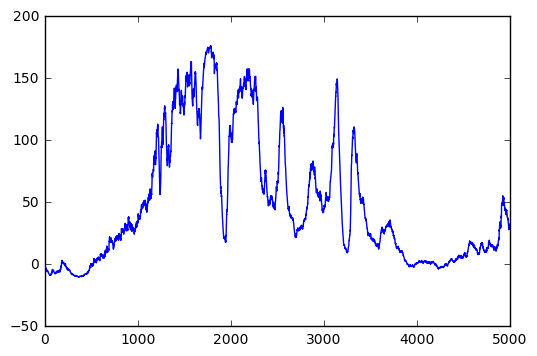

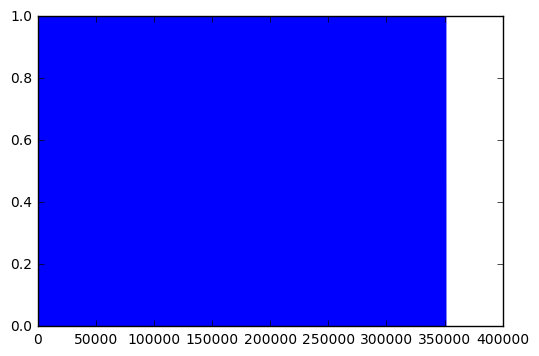

In [3]:
# Init tensorflow
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
env = gym.make('CartPole-v0')
gamma = 0.99
loss_log = []
action_log = []
rsum_log = [0]


for episode in range(5000):
    s = env.reset()
    rsum = 0
    for step in range(200):
        prob = sess.run(tf_prob, feed_dict={tf_obs_a:[s]})[0]
        action = np.random.choice([0, 1], p=prob)
        action_log.append(action)
        s1, r, d, info = env.step(action)
        if d:  r = -20
        rsum += r
        # Training
        v1 = sess.run(tf_v, feed_dict={tf_obs_c:[s1]})
        v = sess.run(tf_v, feed_dict={tf_obs_c:[s]})
        target_v = r + gamma * v1
        if d: target_v = r
        # train critic network
        _, loss = sess.run([trainer_c, loss_c], feed_dict={tf_obs_c:[s], 
                                                           tf_target_v:np.array([[target_v]])})
        
        # train actor network, use td error as advantage
        td_error = target_v - v
        _, act_prob, one_hot, one_prob = sess.run([trainer_a, tf_prob, tf_action_onehot, tf_act_prob], 
                                                           feed_dict={tf_obs_a:[s],
                                                           tf_action:action,
                                                           tf_advantage:td_error})
        #print one_hot
        #print act_prob, one_hot, one_prob
        
        if d: break
        s = s1
        loss_log.append(loss)
    # End of episode
    rsum_log.append(rsum * 0.05 + rsum_log[-1] * 0.95)
    if episode % 100 == 0:
        print 'episode:', episode, 'rsum:', rsum_log[-1]
#plt.plot(loss_log)
#plt.show()
plt.plot(rsum_log) 
plt.show()
plt.plot(action_log)
plt.show()

In [ ]:
# show
for episode in range(200):
    s = env.reset()
    for step in range(200):
        prob = sess.run(tf_prob, feed_dict={tf_obs_a:[s]})[0]
        action = np.random.choice([0, 1], p=prob)
        s1, r, d, info = env.step(action)
        env.render()
        s = s1
        if d: break
        
